In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

plt.style.use('Joey')

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import mossbauer

from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d

from os.path import join

from tqdm import tqdm

In [3]:
def change_axis_color(ax, color, x_or_y='y'):
    getattr(ax, x_or_y + 'axis').label.set_color(color)
    ax.tick_params(axis=x_or_y, colors=color)
    return

## Mossbauer model

The model lives inside the `MossbauerMeasurement()` class. The measurement is broken into three parts:

1. Source (class `MossbauerSource()`): produces an energy spectrum of photons in velocity units
2. Absorber (class `MossbauerAbsorber()`): has an absorption cross-section as a function of energyy
3. Measurement: the geometry of the setup and characteristics of the detector used

When you initialize the class, you have to give it three arguments, one for each of these parts. The first two can either be an instance of their classes, or a dictionary of kwargs to instantiate such an instance. This is because we often want to reuse specific absorbers or sources, so I've made subclasses for these at `mossbauer.materials.py`.

First, let's just start from scratch with a simple measurement:

In [4]:
### source parameters
source_parameters = dict(
    Eres=0.0,  # single line at 0 mm/s
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),  # linewidth in mm/s
    total_activity=1e3,  # Total rate of recoilless(!) 14 keV photons emitted by the source
)

### absorber parameters
absorber_parameters = dict(
    Eres=0.0,  # single absorption line at 0 mm/s
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),  # linewidth in mm/s
    thickness_normalized=3,  # thickness of absorber in number of resonant mean-free-paths (3 is similar to our reference absorbers)
)

### measurement parameters
PMT_OD = 2 * 2.54  # cm
PMT_distance = 10  # cm
measurement_parameters = dict(
    acquisition_time=30*24*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    detection_efficiency=1.0,  # real one closer to 0.5
)

moss = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters
)

Get absorption spectrum (and derivative) as a function of relative velocity

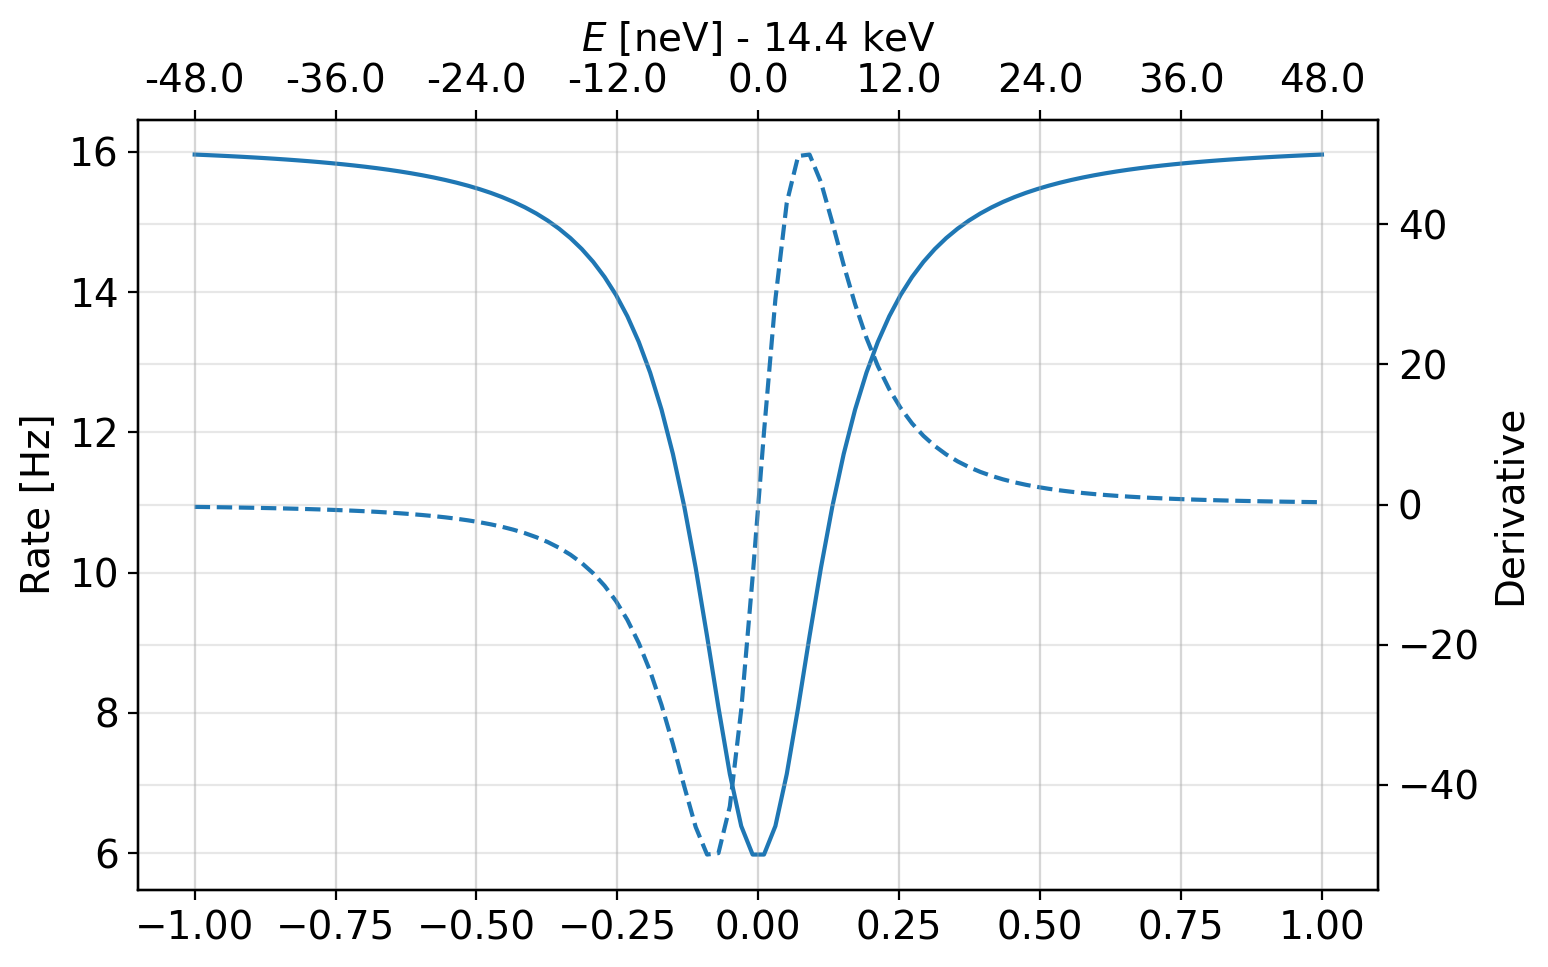

In [5]:
vel = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(1, 1)
plt.plot(vel, moss.transmitted_spectrum(vel))
plt.ylabel('Rate [Hz]')
ax2 = ax.twinx()
plt.plot(vel, moss.transmitted_spectrum_derivative(vel), '--')
plt.ylabel('Derivative')
plt.xlabel('Velocity [mm/s]')

mossbauer.add_energy_axis(ax)  # puts an axis on the top in neV
plt.show()

### Model from existing source/absorber subclasses

See `mossbauer.materials.py` for details on this

In [131]:
from mossbauer.materials import CobaltRhodiumMatrix, AlphaIron

source = CobaltRhodiumMatrix(activity=3.7e7)  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
absorber = AlphaIron(abundance=0.02, thickness_microns=1)
absorber2 = AlphaIron(abundance=1, thickness_microns=0.38)

### measurement parameters
PMT_OD = 2 * 2.54  # cm
PMT_distance = 10  # cm
measurement_parameters = dict(
    acquisition_time=30*24*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    detection_efficiency=1.0,  # real one closer to 0.5
)

moss = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)

moss2 = mossbauer.MossbauerMeasurement(
    source,
    absorber2,
    measurement_parameters
)



{'activity': 37000000.0}
0.050242042687516114
0.019091976221256125


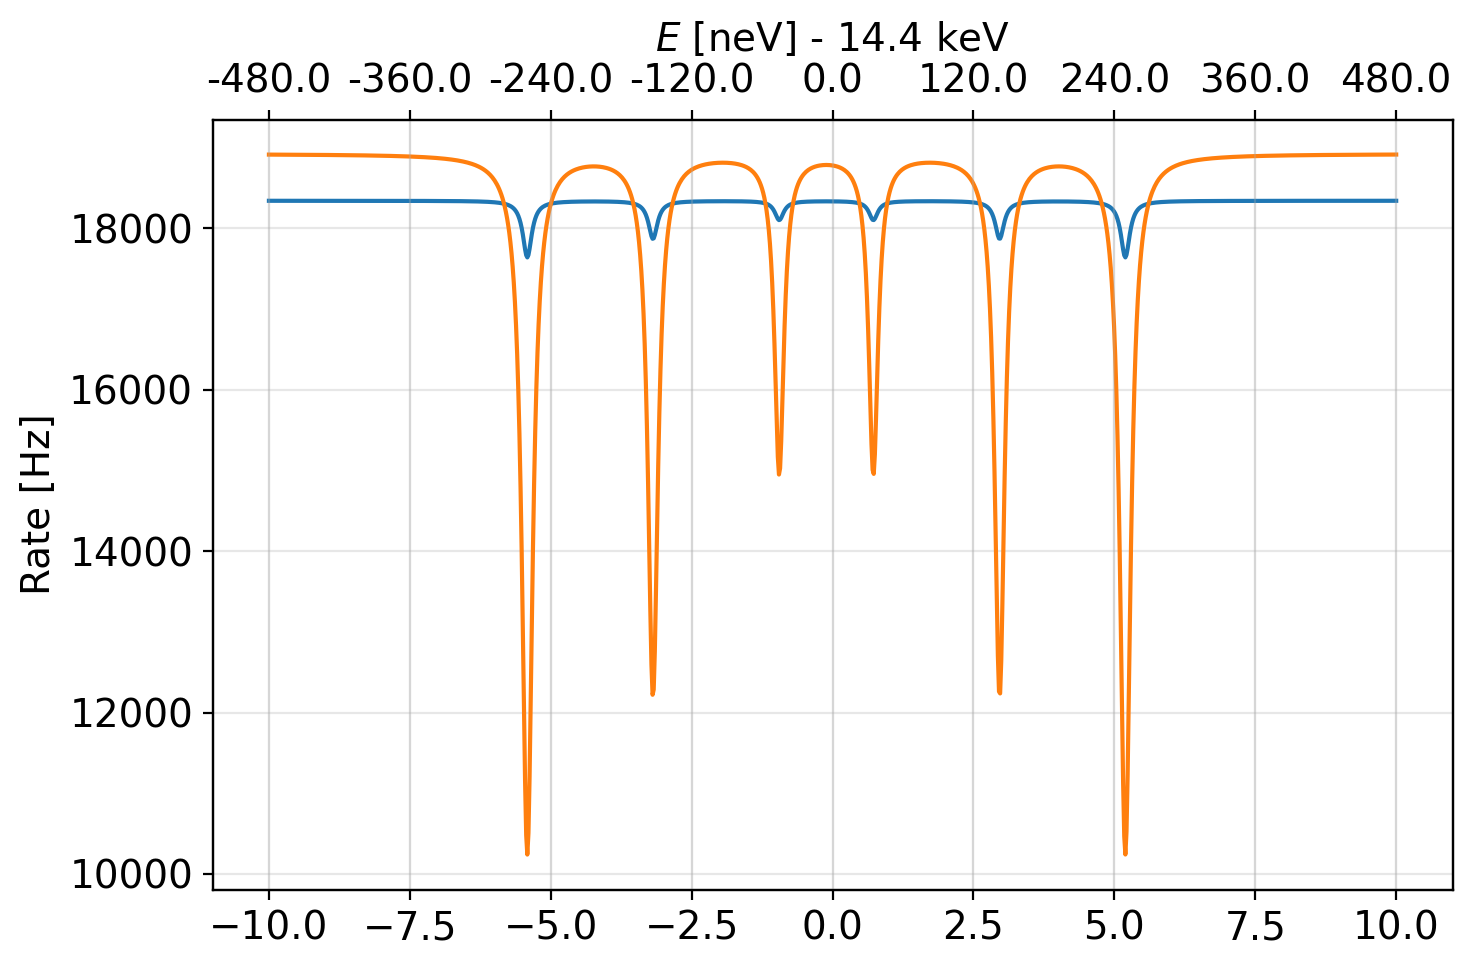

In [132]:
vel = np.linspace(-10, 10, 1000)

fig, ax = plt.subplots(1, 1)
plt.plot(vel, moss.transmitted_spectrum(vel)) 
plt.plot(vel, moss2.transmitted_spectrum(vel))# NOTE: derivative doesn't work for multi-line spectra
plt.ylabel('Rate [Hz]')

mossbauer.add_energy_axis(ax)
plt.show()

You can also look at the info of the source and absorber alone

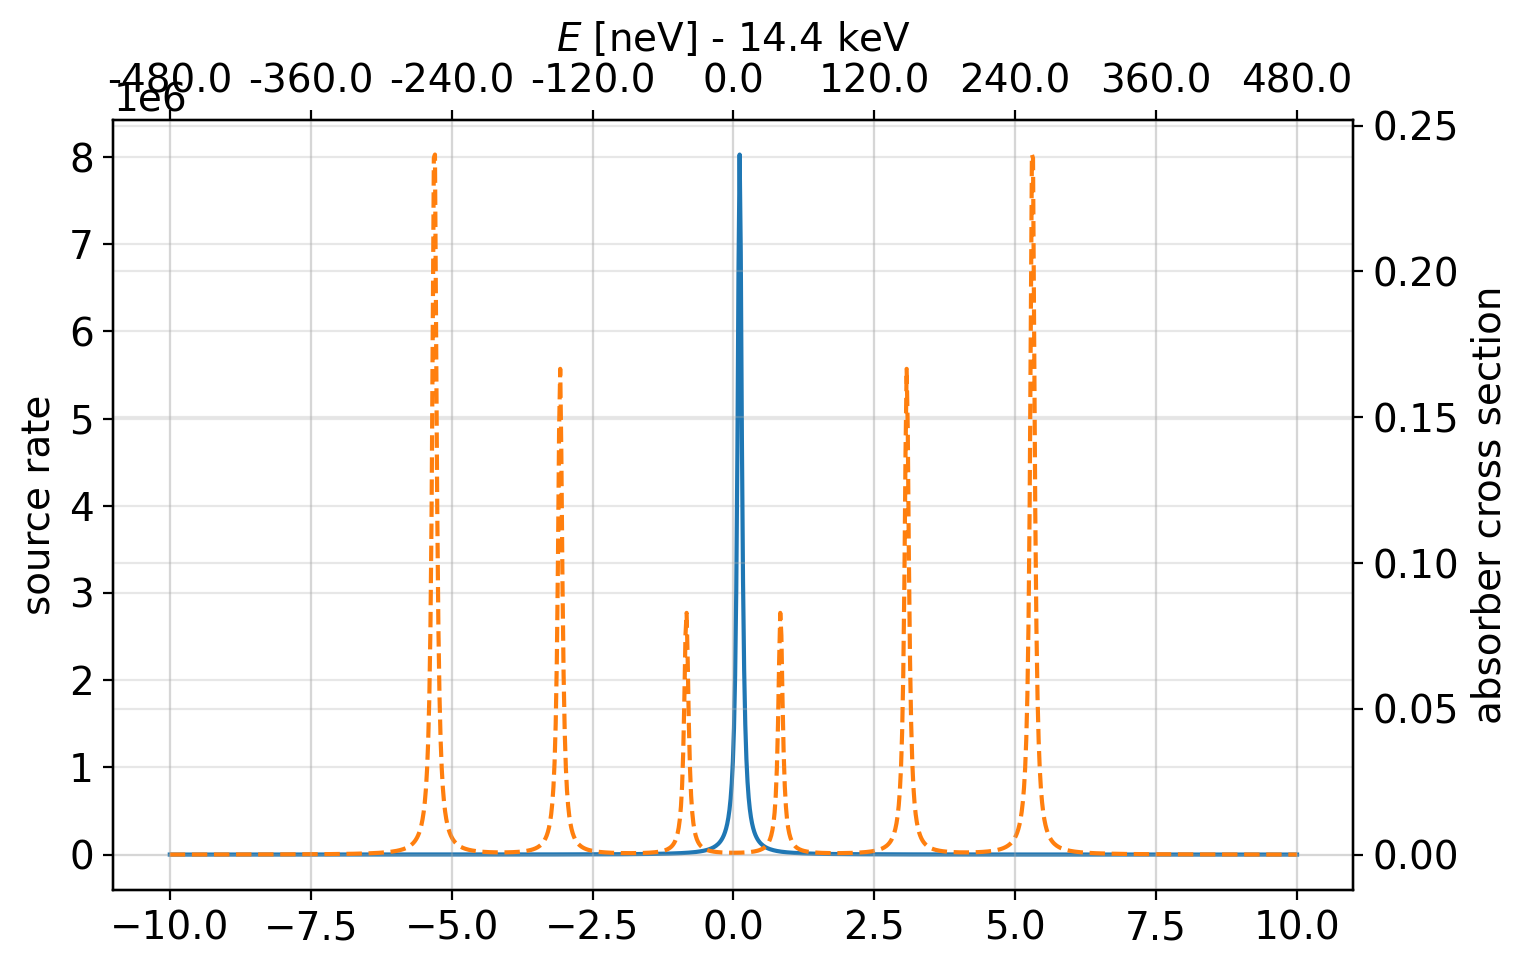

In [8]:
fig, ax = plt.subplots(1, 1)
plt.plot(vel, source.spectrum(vel))
plt.ylabel('source rate')
ax2 = ax.twinx()
plt.plot(vel, absorber.cross_section(vel), 'C1--')
plt.ylabel('absorber cross section')
plt.xlabel('vel [mm/s]')
mossbauer.add_energy_axis(ax)
plt.show()

### Check deltaEmin as a function of measurement velocity
careful: this is not really done with the multiline source!

In [120]:
import xraydb

mossbauer_relative_intensity = 0.0916
source_recoilless_fraction = 1.0
source_activity_Hz =3.7e10 * 0.1  # 100 mCi

acquisition_time = 3600.0 * 50


### source parameters
source_parameters = dict(
    Eres=0.0,
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),
    total_activity=source_activity_Hz * mossbauer_relative_intensity * source_recoilless_fraction
)

### absorber parameters
recoilless_fraction_A = 1.
t_mgcm2 = 0.13  # potassium ferrocyanide from ritverc
absorption_coefficient = 25.0  # cm^2 / mgFe57  (doublecheck)
absorber_parameters = dict(
    Eres=0.0,
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),
    thickness_normalized=t_mgcm2 * absorption_coefficient * recoilless_fraction_A
)


### absorber parameters
thickness_microns = 0.368
Fe57_abundance = 1
iron_density = 7.87  # g/cm3
thickness_gcm2_Fetot = thickness_microns / 1e4 * iron_density
thickness_mgcm2_Fe57 = thickness_gcm2_Fetot * 1e3 * Fe57_abundance
resonant_absorption_coefficient = 25.0  # cm^2/mgFe57
mass_absorption_coef = xraydb.mu_elam('Fe', 14.4e3) 
recoilless_fraction = 0.8
optical_depth = thickness_gcm2_Fetot * mass_absorption_coef

absorber_parameters = dict(
            Eres=0,
            linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),
            thickness_normalized=thickness_mgcm2_Fe57 * resonant_absorption_coefficient * recoilless_fraction,
            optical_depth=thickness_gcm2_Fetot * mass_absorption_coef
        )

### measurement parameters
PMT_OD = 4 
PMT_distance = 10
solid_angle_fraction = (PMT_OD / PMT_distance)**2.0 / 16
measurement_parameters = dict(
    acquisition_time=acquisition_time,
    solid_angle_fraction=solid_angle_fraction,
    background_rate = 1e6,
    detection_efficiency=0.9
)

moss = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters
)

In [121]:
'%.2e' % (moss.source.total_activity * moss.solid_angle_fraction)

'3.39e+06'

In [122]:
'%.2e' % (moss.source.total_activity * moss.solid_angle_fraction * moss.acquisition_time)

'6.10e+11'

In [123]:
vels = moss.source.linewidth*np.logspace(-6, 2, 10000)
slope_vel, slope_rate, vnew = moss.get_deltaEmin_full_old(return_vels=True)
rates = moss.transmitted_spectrum(vels)

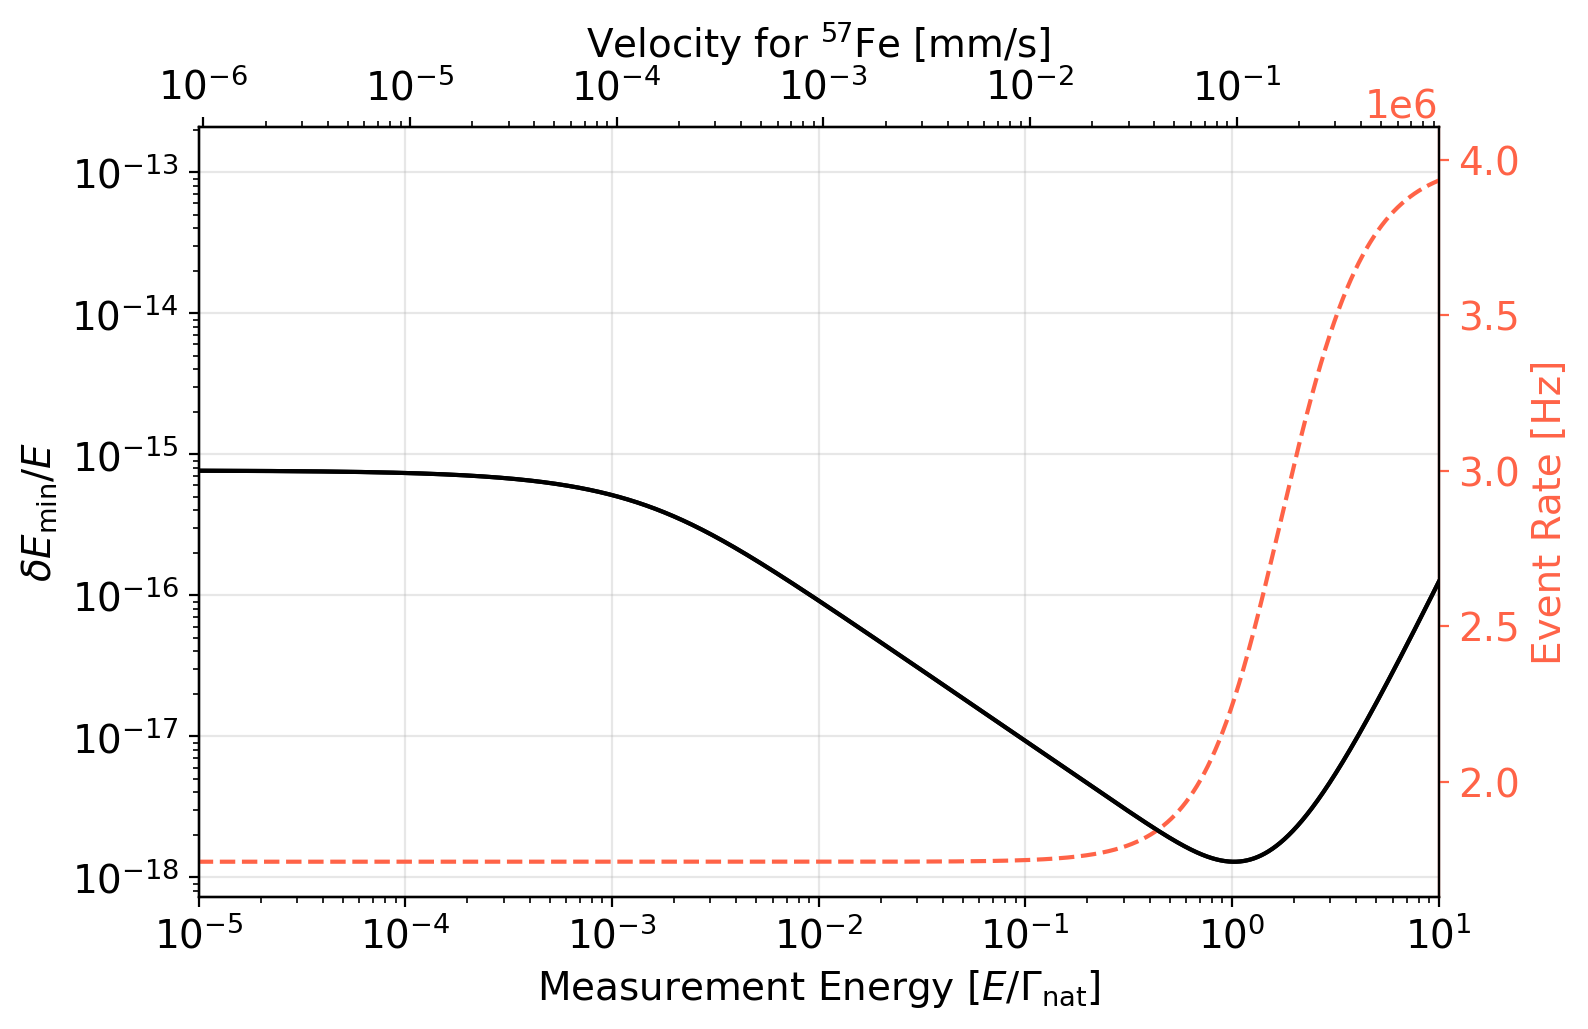

In [124]:
fig, ax = plt.subplots()
plt.plot(vels/mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth), mossbauer.vel_to_E(vnew)/14.4e3, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Measurement Energy [$E/\Gamma_\mathrm{nat}$]')
plt.ylabel('$\delta E_\mathrm{min}/E$')

ax2 = ax.twinx()
ax2.grid(False)
plt.plot(vels/mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth), rates, linestyle='--', color='tomato')
plt.ylabel('Event Rate [Hz]')
change_axis_color(ax2, 'tomato')
ax2.spines['right'].set_color('tomato')
plt.xlim([1e-5, 1e1])


ax3 = ax.twiny()
plt.plot(vels, mossbauer.vel_to_E(vnew)/14.4e3, color='k')
plt.xscale('log')
xrange = np.array(ax.get_xlim())
ax3.set_xlim(xrange*mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth))
ax3.grid(False)
plt.xlabel('Velocity for $^{57}$Fe [mm/s]')

if False:
    plt.savefig('plots/sensitivity_fvs_velocity_closed_form_only.png', dpi=200)
plt.show()

### Thickness broadening

In [65]:
ts = np.logspace(-2, 2, 100)
deltaE_opt = np.zeros_like(ts)

for i, t in enumerate(tqdm(ts)):
    moss.absorber.thickness_normalized = t
    # the linear approximation works pretty well for this, but doing full just to check
    #ans = moss.get_deltaEmin_linear()#vels=np.logspace(-4, 0, 1000), acquisition_time=acquisition_time)
    ans = moss.get_deltaEmin_full_old()
    deltaE_opt[i] = mossbauer.vel_to_E(ans[2])

moss.absorber.thickness_normalized = t_mgcm2 * absorption_coefficient * recoilless_fraction_A

100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


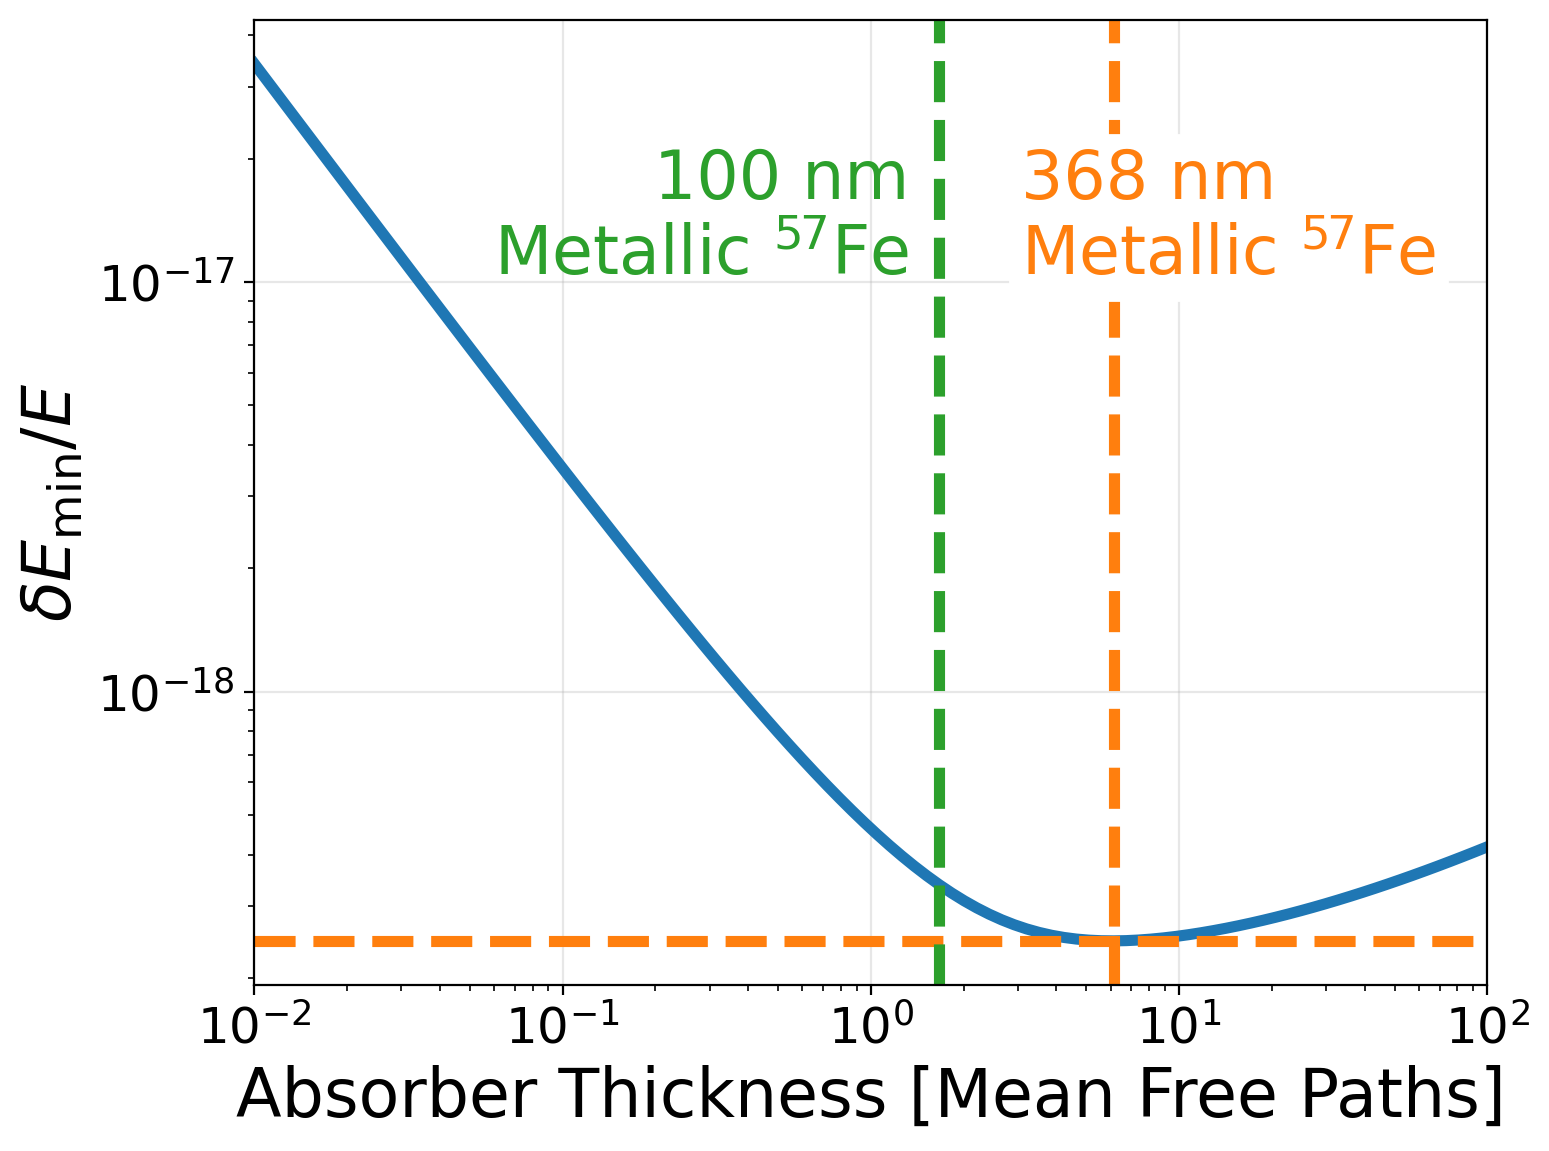

In [134]:
t_exp = (100./48)*0.8
#plt.plot(ts, deltaE, lw=3)
fig, ax = plt.subplots(figsize=(8, 6))
fsize = 24
plt.plot(ts, deltaE_opt/14.4e3, lw=4)
tmin = ts[np.argmin(deltaE_opt)]
plt.axvline(tmin, color='C1', linestyle='--', lw=4)
plt.axhline(deltaE_opt.min()/14.4e3, color='C1', linestyle='--', lw=4)
plt.annotate('%d nm\nMetallic $^{57}$Fe' % (tmin * 48/.8), (tmin*0.5, 1.5e-13/14.4e3), color='C1', fontsize=fsize, bbox=dict(color='w'))
plt.axvline(t_exp, color='C2', linestyle='--', lw=4)
plt.annotate('100 nm\nMetallic $^{57}$Fe' , (t_exp*0.8, 1.5e-13/14.4e3), color='C2', ha='right', fontsize=fsize)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Absorber Thickness [Mean Free Paths]', fontsize=fsize)
plt.ylabel(r'$\delta E_\mathrm{min}/E$', fontsize=fsize)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.xlim([0.01, 100])
plt.tight_layout()
if False:
    plt.savefig('plots/effective_absorber_thickness_vs_sensitivity.png')
plt.show()

### Sensitivity

The sensitivity calculation is sequestered in `physics.py` because its a bit of a black box how to go from $\delta E$ to this space. I've mostly filed all this under the title "physics" and left it to Surjeet. In my opinion it anyway makes the most sense to compare sensitivities in terms of $\delta E$ directly, as this is our actual experimental observable. And this calculation also comes from the above `MossbauerMeasurement.get_deltaEmin_full()`.

But for proposals and stuff, I took the function below from Surjeet.

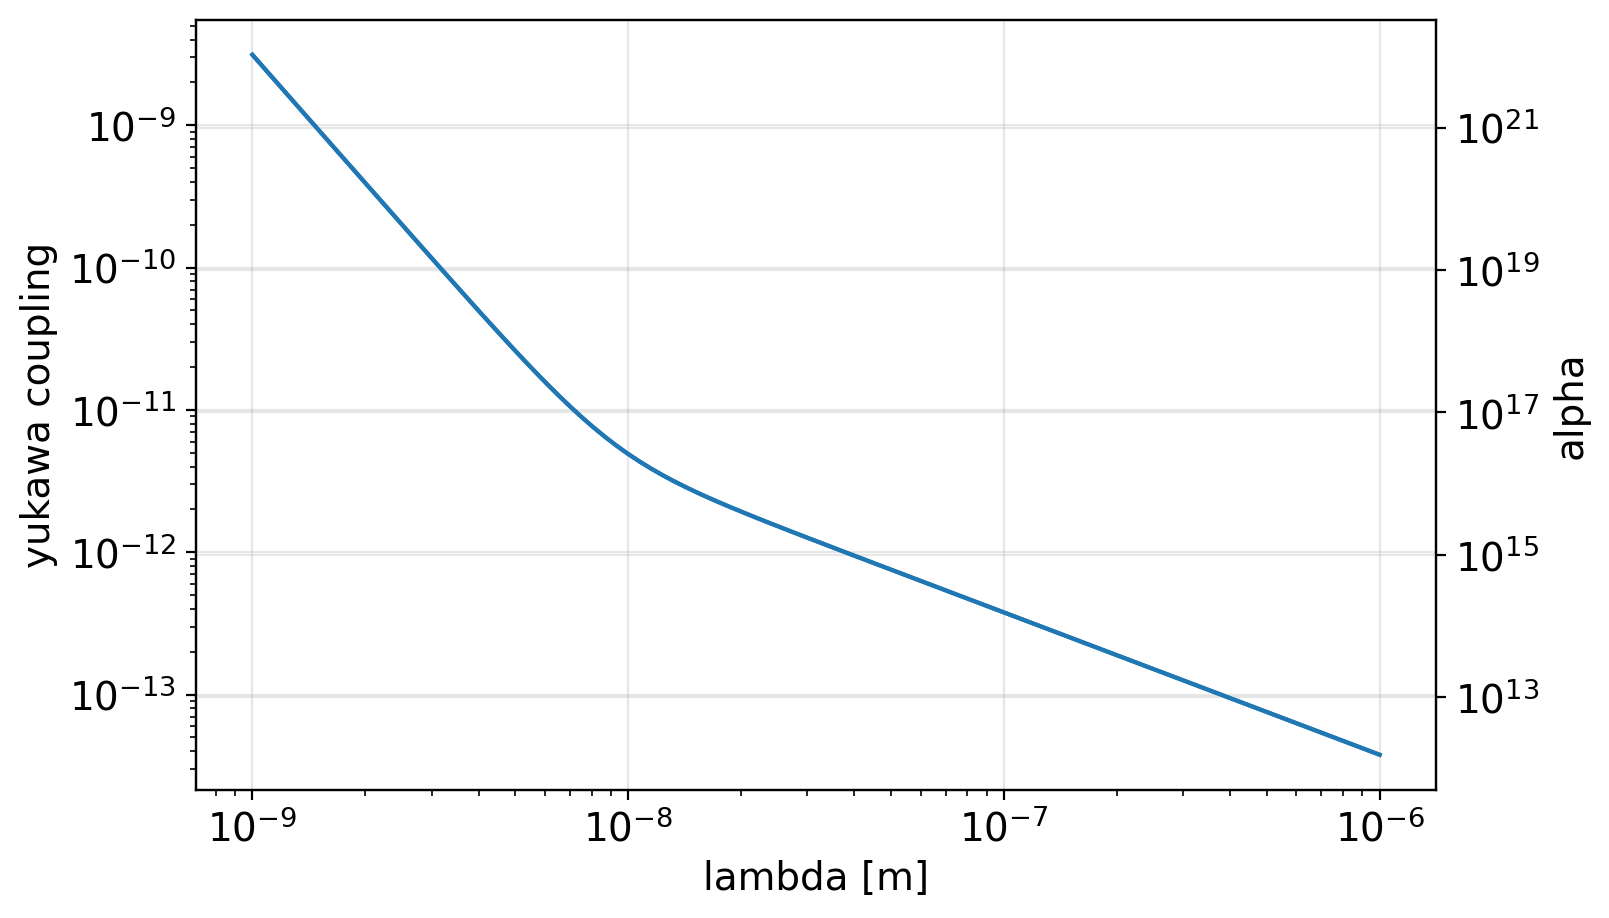

In [74]:
deltaEmin = mossbauer.vel_to_E(moss.get_deltaEmin_full_old()[2])  # actual experimental observable
r, (yuk, alpha) = moss.get_sensitivity(deltaEmin, 'down_quark')  # physics function from Surjeet

fig, ax = plt.subplots(1, 1)
plt.plot(r, yuk)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda [m]')
plt.ylabel('yukawa coupling')

ax2 = ax.twinx()
plt.yscale('log')
plt.ylabel('alpha')
plt.plot(r, alpha)

plt.show()